In [1]:
import os
from pathlib import Path
from tqdm.notebook import tqdm
from itertools import accumulate
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tools.utils import *

import plotly.graph_objects as go

import dash
from dash import dcc
from dash import html

# OKVQA - data investigations

This notebook examines the OKVQA dataset text side. The attributes and building of the dataset follows the configuration used by the widely applied [VQA dataset](https://visualqa.org/download.html). 

## 1) Load data
We start by loading the OKVQA datasets. Since we run models through the [MMF framework](https://github.com/facebookresearch/mmf) we mainly utilize the data provided by them. Through research online and initial investigations, this data is the same as the official one provided by the creators of the OKVQA dataset, with the small variation, that the MMF data only have string answers where the official dataset holds answers in a dictionary structure of raw string answers, modified string answers and whether the answers was given confidently or not. This means, that the annotation-files from the official OKVQA creators are a bit more expressive for which reason we merge data from the two sources for these investigations.

First we load the official data annotations!

In [2]:
# load okvqa dataset annotations (from official site)
filenames = ['train_annotations.json', 'val_annotations.json']
data_path = Path(os.getcwd()) / 'data/official_okvqa'


annotations = {}
for filename in filenames:
    print(f"\n{'-'*50}\nLoading {filename}...\n{'-'*50}")
    name = filename.split('.')[0].split("_")[0]
    annotations[name], q_type = loadData(filename, data_path)

annotations['full'] = pd.concat([annotations[key] for key in annotations.keys()]).reset_index().drop('index', axis=1)


--------------------------------------------------
Loading train_annotations.json...
--------------------------------------------------
Dataset specs:
question_types: {'eight': 'Plants and Animals', 'nine': 'Science and Technology', 'four': 'Sports and Recreation', 'six': 'Geography, History, Language and Culture', 'two': 'Brands, Companies and Products', 'other': 'Other', 'one': 'Vehicles and Transportation', 'five': 'Cooking and Food', 'ten': 'Weather and Climate', 'seven': 'People and Everyday life', 'three': 'Objects, Material and Clothing'}
license: {'url': 'http://creativecommons.org/licenses/by/4.0/', 'name': 'Creative Commons Attribution 4.0 International License'}
info: {'year': 2019, 'version': '1.0', 'description': 'This is v1.0 of the OK-VQA dataset.'}
data_subtype: train2014
data_type: mscoco

--------------------------------------------------
Loading val_annotations.json...
--------------------------------------------------
Dataset specs:
question_types: {'eight': 'Plant

Next we load the data downloaded through MMF. As you can see, the structure is a bit different.

In [3]:
# path to okvqa dataset (from mmf)
data_path = Path.home() / '.cache/torch/mmf/data/datasets/okvqa/defaults/annotations/annotations'
filenames = ['imdb_train.npy', 'imdb_test.npy', 'imdb_val.npy', 'imdb_trainval.npy']

data_path = Path(os.getcwd()) / 'data/mmf/okvqa'

okvqa = {}
for filename in filenames:
    print(f"\n{'-'*50}\nLoading {filename}...\n{'-'*50}")
    name = filename.split('.')[0].split('_')[1]
    okvqa[name], _ = loadData(filename, data_path)


--------------------------------------------------
Loading imdb_train.npy...
--------------------------------------------------
Dataset specs:
create_time: 2020-09-03 13:40:00.451863
dataset_name: okvqa
version: 1.1
has_answer: True
has_gt_layout: False
created_at: 1599165600.4518836

--------------------------------------------------
Loading imdb_test.npy...
--------------------------------------------------
Dataset specs:
create_time: 2020-09-03 13:39:59.718679
dataset_name: okvqa
version: 1.1
has_answer: True
has_gt_layout: False
created_at: 1599165599.718699

--------------------------------------------------
Loading imdb_val.npy...
--------------------------------------------------
Dataset specs:
create_time: 2020-09-03 13:40:00.642192
dataset_name: okvqa
version: 1.1
has_answer: True
has_gt_layout: False
created_at: 1599165600.6422124

--------------------------------------------------
Loading imdb_trainval.npy...
--------------------------------------------------
Dataset specs:

## 2) Initial investigation

Before merging the dataframes, let's investigate them slightly and make sure that they are in the same format.

As given by the creators of the [OKVQA dataset](https://okvqa.allenai.org/), there are 14,055 open-ended questions in the dataset. Let's figure out how this relates to the data that we just loaded...

In [4]:
okvqa['train'].shape[0] + okvqa['test'].shape[0] + okvqa['val'].shape[0] + okvqa['trainval'].shape[0]

23064

This is much larger than what is stated by the creators of the OKVQA dataset. But wait a second... One of the datafiles provided by MMF is called `imdb_trainval.npy` - what happens if we ignore this?

In [5]:
okvqa['train'].shape[0] + okvqa['test'].shape[0] + okvqa['val'].shape[0]

14055

Alright! So the trainval is probably just a combination of the training and validation data - let's quickly verify this...

In [6]:
okvqa['train'].shape[0] + okvqa['val'].shape[0] == okvqa['trainval'].shape[0]

True

Indeed that is true! Let's ignore the `imdb_train.npy` and `imdb_trainval.npy` files and inspect the training data as the mix of these and compare it to the test data.

In [7]:
okvqa['full'] = pd.concat([okvqa['trainval'], okvqa['test']]).reset_index().drop('index', axis=1)

print(f"Shape of dataframe: {okvqa['full'].shape}")
okvqa['full'].head()

Shape of dataframe: (14055, 9)


,image_id,question_id,question_str,question_tokens,all_answers,answers,image_name,feature_path,ocr_tokens
0,51606,516065,What is the hairstyle of the blond called?,"[what, is, the, hairstyle, of, the, blond, cal...","[pony tail, pony tail, pony tail, pony tail, p...","[pony tail, pony tail, pony tail, pony tail, p...",COCO_train2014_000000051606,COCO_train2014_000000051606.npy,[]
1,81721,817215,How old do you have to be in canada to do this?,"[how, old, do, you, have, to, be, in, canada, ...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]",COCO_train2014_000000081721,COCO_train2014_000000081721.npy,[]
2,480208,4802085,Can you guess the place where the man is playing?,"[can, you, guess, the, place, where, the, man,...","[aspen, aspen, mountain, mountain, mountain, m...","[aspen, aspen, mountain, mountain, mountain, m...",COCO_train2014_000000480208,COCO_train2014_000000480208.npy,[]
3,570618,5706185,Which rail company is named after a town in ne...,"[which, rail, company, is, named, after, a, to...","[santa fe, santa fe, santa fe, santa fe, new e...","[santa fe, santa fe, santa fe, santa fe, new e...",COCO_train2014_000000570618,COCO_train2014_000000570618.npy,[]
4,478903,4789035,Is the boy swimming or doing another water act...,"[is, the, boy, swimming, or, doing, another, w...","[another activity, another activity, another a...","[another activity, another activity, another a...",COCO_train2014_000000478903,COCO_train2014_000000478903.npy,[]


As for the annotations from the official data provider we already have files for the train, test and full data splits. Let's see if they match the ones found from MMF. 

In [8]:
# for compatibility with mmf
annotations['test'] = annotations['val']

# train data Image-Question pairs identical?
print("Train data indeces identical?")
print((annotations['train'][['image_id', 'question_id']] == okvqa['trainval'][['image_id', 'question_id']]).all())

# test data Image-Question pairs identical?
print("\nTest data indeces identical?")
print((annotations['test'][['image_id', 'question_id']] == okvqa['test'][['image_id', 'question_id']]).all())

Train data indeces identical?
image_id       True
question_id    True
dtype: bool

Test data indeces identical?
image_id       True
question_id    True
dtype: bool


Before blindly throwing out the answer-structure provided in the official dataset, let's see if the answer-confidence - that is whether the annotators were confident with their answers - have a say in the dataset. Maybe the `confidence` attribute is enough? 

In [9]:
# for all questions, check if 1 or more answers are not confident ('yes')
confidence = annotations['full'].answers.apply(lambda answer_list: all([True if answer_dict['answer_confidence'] == 'yes' else False for answer_dict in answer_list]))

# check whether any of the questions have an annotator that was unconfident
(-confidence).any()

False

Interesting observation! All annotators were confident with their answer for all questions. This gives the first hint to the complexity of the questions - they might not be to hard, but let's exploit that later on...

So everything seems to be alright! Later on, we want to exploit the `answer_type`, `question_type` as well as the `confidence` attributes from the official OKVQA dataset. Let's now merge the dataframes such that we keep the expressiveness from the official OKVQA dataset along with the simplicity of answer representations from the MMF downloaded version.

In [10]:
attributes_to_keep = ['image_id', 'question_id', 'answer_type', 'question_type', 'confidence']
okvqa['full'] = pd.merge(annotations['full'][attributes_to_keep], okvqa['full'])
okvqa['full'].head()

,image_id,question_id,answer_type,question_type,confidence,question_str,question_tokens,all_answers,answers,image_name,feature_path,ocr_tokens
0,51606,516065,other,four,3,What is the hairstyle of the blond called?,"[what, is, the, hairstyle, of, the, blond, cal...","[pony tail, pony tail, pony tail, pony tail, p...","[pony tail, pony tail, pony tail, pony tail, p...",COCO_train2014_000000051606,COCO_train2014_000000051606.npy,[]
1,81721,817215,other,seven,5,How old do you have to be in canada to do this?,"[how, old, do, you, have, to, be, in, canada, ...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]",COCO_train2014_000000081721,COCO_train2014_000000081721.npy,[]
2,480208,4802085,other,four,2,Can you guess the place where the man is playing?,"[can, you, guess, the, place, where, the, man,...","[aspen, aspen, mountain, mountain, mountain, m...","[aspen, aspen, mountain, mountain, mountain, m...",COCO_train2014_000000480208,COCO_train2014_000000480208.npy,[]
3,570618,5706185,other,one,2,Which rail company is named after a town in ne...,"[which, rail, company, is, named, after, a, to...","[santa fe, santa fe, santa fe, santa fe, new e...","[santa fe, santa fe, santa fe, santa fe, new e...",COCO_train2014_000000570618,COCO_train2014_000000570618.npy,[]
4,478903,4789035,other,seven,2,Is the boy swimming or doing another water act...,"[is, the, boy, swimming, or, doing, another, w...","[another activity, another activity, another a...","[another activity, another activity, another a...",COCO_train2014_000000478903,COCO_train2014_000000478903.npy,[]


In [11]:
q_type

{'eight': 'Plants and Animals',
 'nine': 'Science and Technology',
 'four': 'Sports and Recreation',
 'six': 'Geography, History, Language and Culture',
 'two': 'Brands, Companies and Products',
 'other': 'Other',
 'one': 'Vehicles and Transportation',
 'five': 'Cooking and Food',
 'ten': 'Weather and Climate',
 'seven': 'People and Everyday life',
 'three': 'Objects, Material and Clothing'}

## 2) Questions

Let's look at the questions of the dataset. It is evident that 3 attributes are associated to the questions, namely `question_id`, `question_str` and `question_tokens`. `question_id` is used within the MMF framework to call for specific image/question pairs and they are thus unique. `question_str` (and hence `question_tokens`) are not..

In [12]:
print(f"question id's unique? {okvqa['full'].question_id.is_unique}")
print(f"question strings unique? {okvqa['full'].question_str.is_unique}")

question id's unique? True
question strings unique? False


In [13]:
okvqa['full'].question_str.unique().__len__()

12591

In [14]:
sorted(Counter(okvqa['full'].question_str).items(), key=lambda x: x[1], reverse=True)

[('What breed of dog is this?', 30),
 ('What time of day is it?', 29),
 ('What sport is this?', 25),
 ('What kind of bird is this?', 25),
 ('Where is this?', 23),
 ('What type of bird is this?', 22),
 ('What type of dog is this?', 18),
 ('What breed of cat is this?', 17),
 ('What food is this?', 17),
 ('What event is this?', 16),
 ('What food does this animal eat?', 16),
 ('What do these animals eat?', 16),
 ('What is this room used for?', 15),
 ('What kind of dog is this?', 14),
 ('What century is this?', 14),
 ('What is the weather like?', 14),
 ('What food does the animal eat?', 14),
 ('What activity is this?', 12),
 ('What food do these animals eat?', 12),
 ('What city is this?', 11),
 ('What kind of birds are these?', 11),
 ('What is this used for?', 11),
 ('What type of food is this?', 10),
 ('What type of plane is this?', 10),
 ('What is this vehicle used for?', 9),
 ('What kind of truck is this?', 9),
 ('What does this animal eat?', 9),
 ('What species of bird is this?', 9),
 (

Going one step further, we analyze the textual content of the question data. Let's start looking at the start words of the question as they can be considered kind of representatives of the complexity of the questions.

Number of start word index (sorted): 164


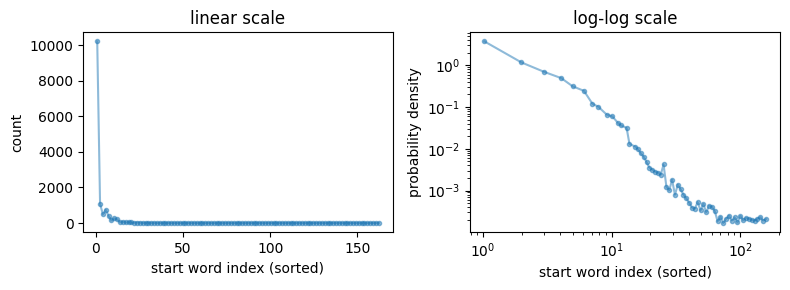

,start word,percentage
0,what,66.040555
1,how,6.623977
2,is,4.034152
3,where,3.600142
4,which,3.464959
5,who,2.710779
6,why,2.575596
7,the,1.465671
8,name,1.394522
9,when,1.045891


In [15]:
start_words, percentage = investigate_this(lambda x: x[0], okvqa['full'].question_tokens, what='start word index (sorted)')

# modify dataframe
percentage.rename(columns={'attribute':'start word'}, inplace=True)
percentage[percentage.percentage.cumsum() < 97.5]

Analyzing the occurrence frequency on histograms, we see that the distribution is quite like a power law, since it is kind of linear on the log-log plot. This means that many of the first occuring words are quite rare and that some words occur very frequently. It turns out that these high-occuring words only consist of one word and that the 97.5% most occuring words amounts to 17 words.

Let's visualize the questions in a bit more intuitive fashion. Try interacting with the plots below - you can hover the areas or press them if you like!

In [15]:
N = 276
visualization_depth = 15

temp = createSunburstVariables(okvqa['full'], N)
plotSunburst(temp, N, visualization_depth=visualization_depth, use_dash=False, width=900, height=900)

In [46]:
import plotly.express as px

temp['start_words'] = temp.ids.apply(lambda seq: seq.strip("CLS").split(" ")[1:]).apply(lambda x: x[0] if len(x) > 0 else "")
fig = px.pie(temp[temp.parents == 'CLS'], values='occurrences', names='start_words')
fig.update_layout(uniformtext_minsize=21, uniformtext_mode='hide')

fig.show()

Deploy dash app in webpage: https://dash.plotly.com/deployment

This interactive sunburst plot quite intuitively visualize how questions starting with the word *what* are highly dominating the questions. It is clear to see that this is a bias, that might be available to exploit when designing our evaluation setup.

### Complexity
Complexity of questions can be defined in various ways, but one way is to look at the answers. Another way is to look at the questions themselves. So how do we do it best?

We suggest analyzing the question complexity in various ways to get a more holistic understanding of the complexity of the questions in the dataset:
> 1) question length (number of words) \
> 2) answer length (number of words) \
> 3) count the amount of non-agreeing answers to each question and use this as a proxy for complexity. \

Let's begin by looking at number 1).

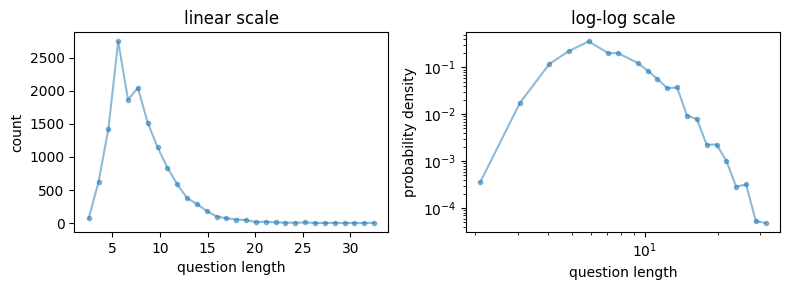

In [88]:
LogAndLinearHist(question_length, xlabel='question length')

Number of question length: 27


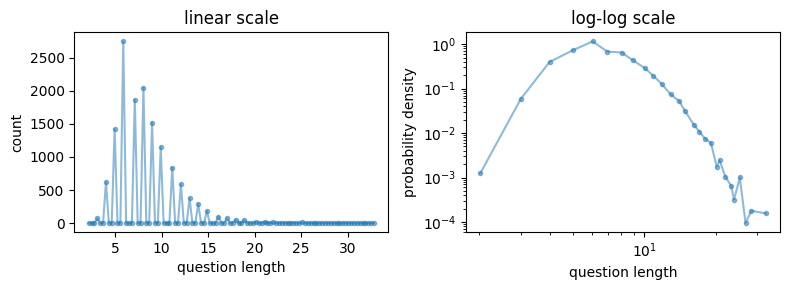

,question_length,percentage
26,2,0.007115
14,3,0.490928
7,4,4.425471
4,5,10.110281
0,6,19.565991
2,7,13.290644
1,8,14.571327
3,9,10.807542
5,10,8.167912
6,11,5.962291


In [17]:
question_length, percentage = investigate_this(lambda x: x.__len__(), okvqa['full'].question_tokens, what='question length', nbins=15)

# modify dataframe
percentage.rename(columns={'attribute':'question_length'}, inplace=True)
percentage.sort_values(by='question_length')

In [33]:
question_length.describe()

count    14055.000000
mean         8.180576
std          2.996817
min          2.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         33.000000
dtype: float64

We observe that there are a total of 14055 questions that vary between having a length of 2 and 33 tokens. The mean and median are both quite similar around 8 tokens per question but are a bit right-skewed which is why the histogram on the linear plot also is a bit right-skewed.

An initial thought about this is, that the questions seem to be of a specific type in terms of question length complexity. There are however some questions that are super long, which would probably increase the complexity drastically due to ambiguity but there are also less complex questions of length 2.

In [34]:
rename = {'question_type':'question_type_num', 0:'count'}
pie_df = okvqa['full'].groupby(by='question_type').size().reset_index().rename(columns=rename)

pie_df['question_type'] = pie_df.question_type_num.map(q_type)
pie_df

,question_type_num,count,question_type
0,eight,2336,Plants and Animals
1,five,2173,Cooking and Food
2,four,1751,Sports and Recreation
3,nine,237,Science and Technology
4,one,2236,Vehicles and Transportation
5,other,1675,Other
6,seven,1222,People and Everyday life
7,six,451,"Geography, History, Language and Culture"
8,ten,358,Weather and Climate
9,three,1145,"Objects, Material and Clothing"


In [35]:
import plotly.express as px

fig = px.pie(pie_df, values='count', names='question_type', title='Distribution of question types in OKVQA')
fig.show()

## 3) Answers
Then what about the answers? Let's start by getting the basics about them - it turns out that each question has 10 answers.

In [19]:
all_answers = okvqa['full'].answers.apply(pd.Series).stack().reset_index(drop=True)

In [26]:
# number of answers per question
np.all(okvqa['full'].answers.apply(lambda x: x.__len__()) == 10)

True

In [52]:
answer ,freq = list(zip(*sorted(Counter(all_answers).items(), key=lambda x: x[1], reverse=True)))

By looking at all the given answers we clearly see that there is some sort of ambiguity and disagreement in the answers, since there are more unique answers than questions.

In [26]:
# number of unique answers

unique = []
for answers in okvqa['full'].answers.apply(lambda x: set(x)):
    for elem in answers:
        unique.append(elem)
print(f"Number of unique answers: {set(unique).__len__()}")

Number of unique answers: 15040


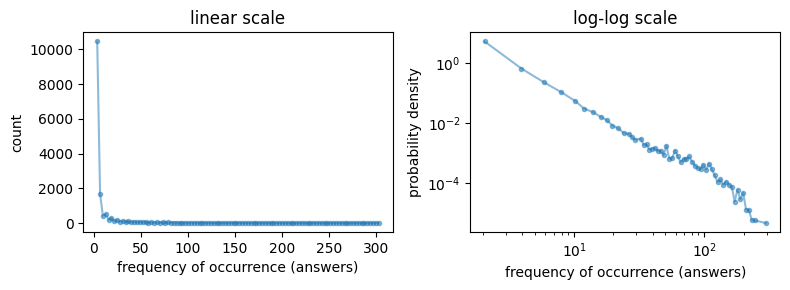

In [40]:
LogAndLinearHist(pd.Series(freq), xlabel='frequency of occurrence (answers)')

In [74]:
answer_lengths = all_answers.apply(lambda x: x.split(" ").__len__())
all_answers[answer_lengths == 19]

5578    he maglev train service began operating in 200...
5579    he maglev train service began operating in 200...
dtype: object

In [78]:
sorted(answer_lengths.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 19]

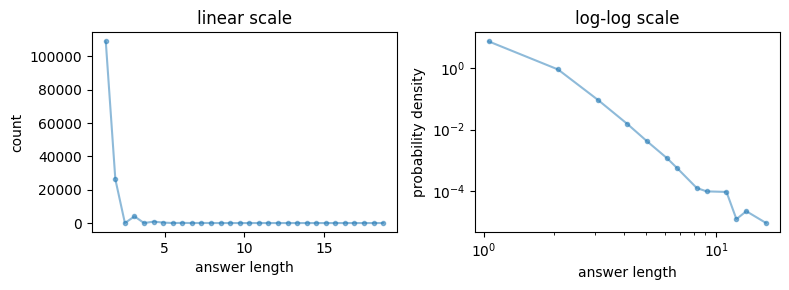

In [89]:
LogAndLinearHist(answer_lengths, xlabel='answer length')

We see that the answers occur in a manner that follows a power law - this means that most answers occur only once but that some answers occur up to around 360 times. That the answers only occur once might be good if we have a zero-shot learning approach in mind.

We can similarly investigate the answer type. As seen below, all answers are of the type `other` which means that there are no binary or numerical answers.

In [30]:
okvqa['full'].answer_type.unique()

array(['other'], dtype=object)

We validate that there indeed are no 'yes' or 'no' answers in the dataset by checking whether they occur in the lists of answers.

In [31]:
okvqa['full'].answers.apply(lambda x: 'yes' in x or 'no' in x).any()

False

With respect to the answers, we average the answer length of the 10 answers for each question, since they might differ in length. Then we use this as the descriptive statistic for our descriptive investigation.

Number of observed differences in avg. answer length: 20


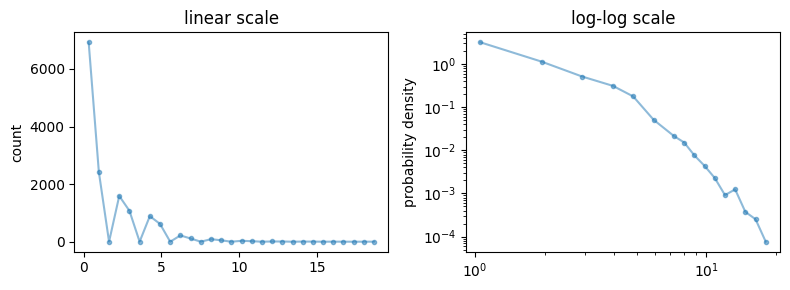

Average answer length lower than two = 91.725%


,answer_length,percentage
0,1.0,49.263607
1,1.2,17.203842
2,1.4,11.305585
3,1.6,7.634294
4,1.8,6.318036
5,2.0,4.397012
6,2.2,1.551049
7,2.4,0.796869
8,2.6,0.626112
9,2.8,0.348630


In [32]:
answer_length, percentage = investigate_this(lambda answer: np.mean([subanswer.split(" ").__len__() for subanswer in answer]), okvqa['full'].answers, what='observed differences in avg. answer length')

# modify dataframe
percentage.rename(columns={'attribute':'answer_length'}, inplace=True)
print(f"Average answer length lower than two = {percentage[percentage.answer_length < 2].percentage.sum():.3f}%")
percentage.sort_values(by='answer_length')

In [33]:
answer_length.describe()

count    14055.000000
mean         1.279360
std          0.398017
min          1.000000
25%          1.000000
50%          1.200000
75%          1.400000
max          7.200000
dtype: float64

With 19 different average answer lengths, we obseve that the average answer length is in general quite low. It is observable from the percentage dataframe, that around 92% of the answers (including variability) consists of single words. There are however questions, that have an average answer length of 7.2. With this distribution of average answer lengths that follows a power law, it seems like the questions are rather simple as most of them are answerable with a single word. This, however, could also be due to an experimental bias, where answers given by the human annotators, have been pruned to their essential parts - either while doing the collection or as a post-processing such that determiner words are removed to solely keep the important content of the answers. In other words - the human annotators might have been told to keep their answers short and to the point, in order to not need a text generation module creating long sequences with SOTA performances to answer the questions.

We'll get back to the outliers (long answers) later... Let's first dig into the fact that the responses on a question might differ. We call this the answer variability and compute the number of different answers for each question as another metric for understanding question complexity.

In [90]:
# variety in answers
answer_variety = okvqa['full'].answers.apply(lambda x: np.unique(x).__len__())
counter = Counter(answer_variety)
attr, freqs = list(zip(*sorted(counter.items(), key=lambda x: x[0])))

In [108]:
attr = list(attr)
attr.insert(0, 0)

freqs = list(freqs)
freqs.insert(1, 0)

In [110]:
freqs

[1701, 0, 2995, 3902, 5299, 158]

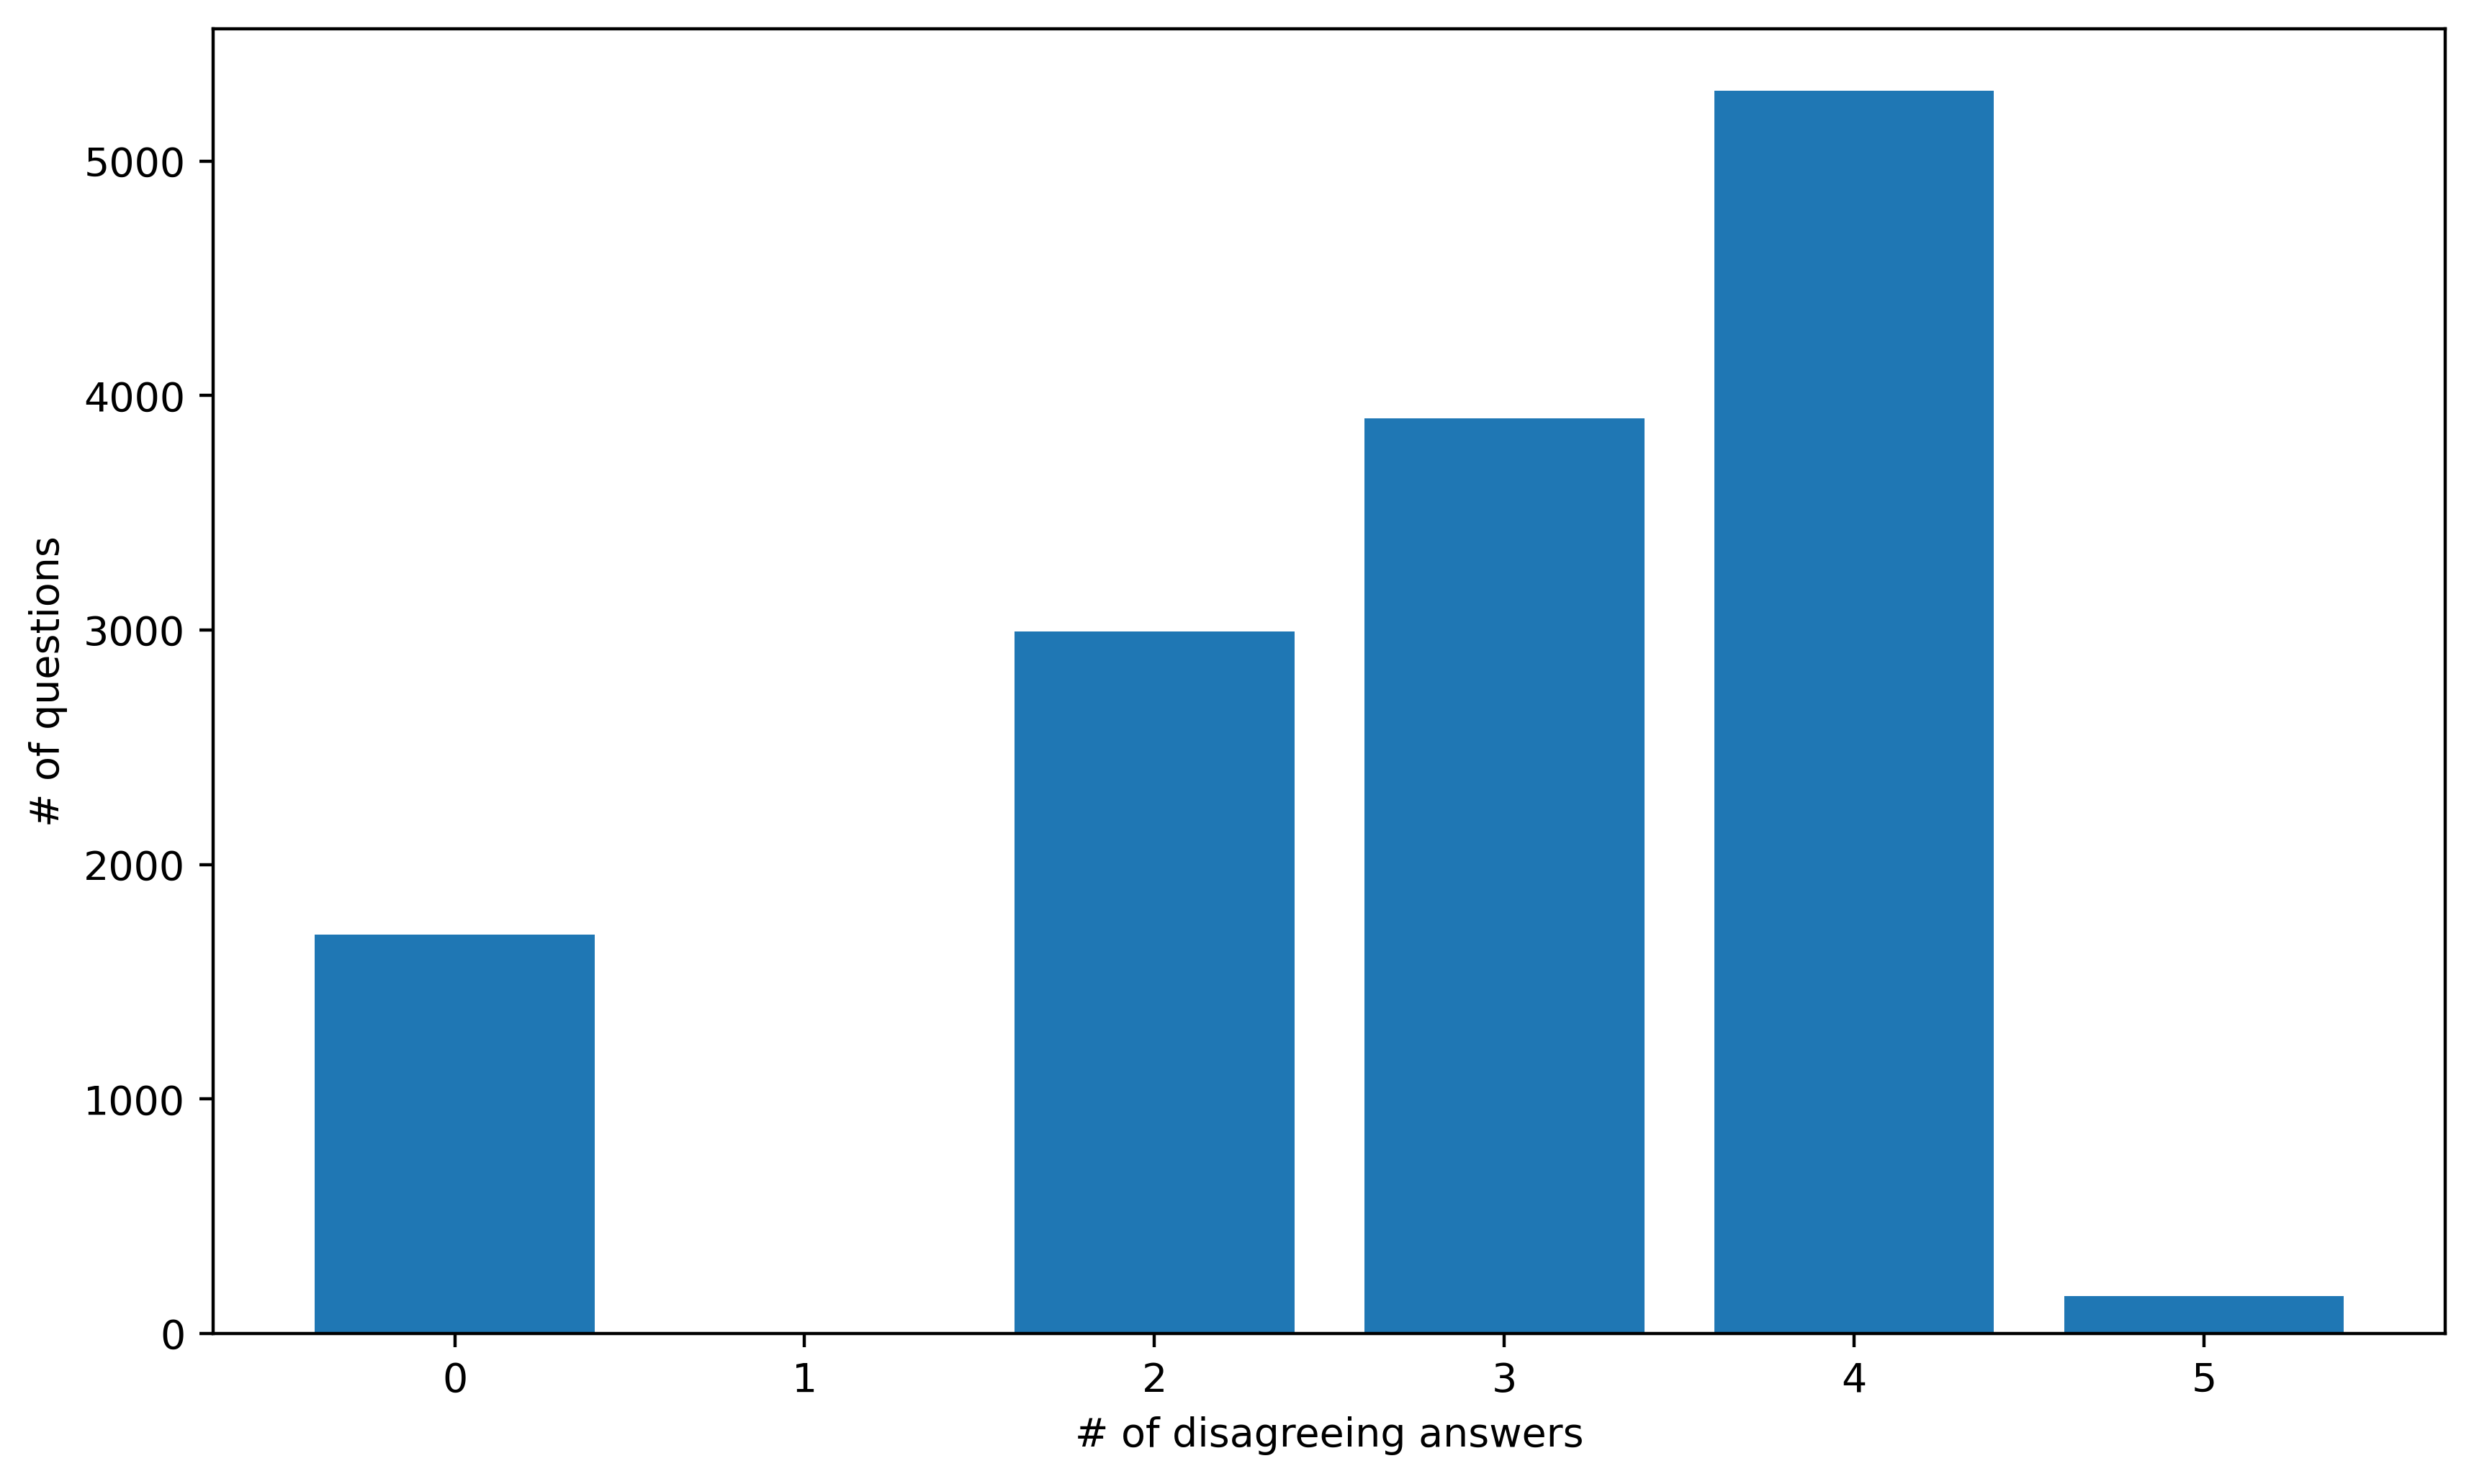

In [113]:
# plot answer variety
plt.figure(figsize=((10,6)), dpi=400)
plt.bar(attr, freqs)
plt.ylabel('# of questions')
plt.xlabel('# of disagreeing answers')
plt.show()

Here, we see that there are quite a lot of questions for which the 10 answers differ, however, not more than 5 persons differing on a question answer. This suggests that the questions are of some complexity that is not trivial - however, it is hard to conclude anything for sure on this investigation since differing answers might simply be due to synonyms or similar phrasings. Let's first gather the attributes in a new dataframe and print out the top and bottom 10 QA-pairs wrt. the answer_variability to manually inspect the patterns.

In [116]:
QA = okvqa['full'][['question_str', 'question_tokens', 'answers', 'question_type']].copy()
QA['question_length'] = QA.question_tokens.apply(lambda x: x.__len__())
QA['answer_length'] = QA.answers.apply(lambda answer: np.mean([subanswer.split(" ").__len__() for subanswer in answer]))
QA['answer_var'] = QA.answers.apply(lambda x: np.unique(x).__len__())

QA.head()

,question_str,question_tokens,answers,question_type,question_length,answer_length,answer_var
0,What is the hairstyle of the blond called?,"[what, is, the, hairstyle, of, the, blond, cal...","[pony tail, pony tail, pony tail, pony tail, p...",four,8,1.6,3
1,How old do you have to be in canada to do this?,"[how, old, do, you, have, to, be, in, canada, ...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]",seven,12,1.0,1
2,Can you guess the place where the man is playing?,"[can, you, guess, the, place, where, the, man,...","[aspen, aspen, mountain, mountain, mountain, m...",four,10,1.2,4
3,Which rail company is named after a town in ne...,"[which, rail, company, is, named, after, a, to...","[santa fe, santa fe, santa fe, santa fe, new e...",one,11,1.8,4
4,Is the boy swimming or doing another water act...,"[is, the, boy, swimming, or, doing, another, w...","[another activity, another activity, another a...",seven,9,1.4,4


In [117]:
print_top(df=QA, attribute='answer_var', n=10)

--------------------------------------------------------------------------------
Top 10 (answer_var) QA-pairs:
--------------------------------------------------------------------------------
Question:
 What type of wires are the birds sitting on?

Answer:
 Counter({'power': 2, 'metal': 2, 'electric': 2, 'phone': 2, 'electrical': 2})

answer_var: 5
--------------------------------------------------------------------------------
Question:
 Which of these desserts is finished with a torch after cooking?

Answer:
 Counter({'danish': 2, 'fire': 2, 'tart': 2, 'creme brulee': 2, 'creme brule': 2})

answer_var: 5
--------------------------------------------------------------------------------
Question:
 People that travel with these strappable types of luggage are often called what?

Answer:
 Counter({'backpack': 2, 'backpacker': 2, 'hiker': 2, 'hike': 2, 'luggage': 2})

answer_var: 5
--------------------------------------------------------------------------------
Question:
 How are the magne

In [118]:
print_bottom(df=QA[QA['answer_var'] != 1], attribute='answer_var', n=10)

--------------------------------------------------------------------------------
Bottom 10 (answer_var) QA-pairs:
--------------------------------------------------------------------------------
Question:
 What are in the suitcases?

Answer:
 Counter({'cloth': 8, 'luggage': 2})

answer_var: 2
--------------------------------------------------------------------------------
Question:
 The child is in what kind of park?

Answer:
 Counter({'skate': 8, 'skate park': 2})

answer_var: 2
--------------------------------------------------------------------------------
Question:
 What makes this water look green?

Answer:
 Counter({'algae': 8, 'sky': 2})

answer_var: 2
--------------------------------------------------------------------------------
Question:
 What type of shoes are those?

Answer:
 Counter({'high heel': 8, 'heel': 2})

answer_var: 2
--------------------------------------------------------------------------------
Question:
 What is the weather in this photo?

Answer:
 Counter({'r

So printing out the counts of the various answers seem to reveal much about this trend: 

1. that QA pairs with high answer variability (5 different answers) have a more or less equally spread out count distribution among the candidate answers
2. that QA pairs with low answer variability (2 different answers) typically are quite agreeing on one of the terms.
3. Some disagreeing answers are synonyms, morphological inflections or simplifications of the other given answers, like `horse race/kentucky derby`, `rain/rainy` or `heel/high heel`.

For point 1) and 2) this suggests to use a weighted disagreement metric instead of the plain count to obtain a more representative similarity metric. For 3) using more advanced and content-based metrics would be ideal - i.e. by mapping answers to an embedding space and computing the cosine similarity.

### Weighted metric of (dis)similarity



In [119]:
#TODO: gridplot of the count distribution within answer-variability groups


### Semantically(-ish) analysis of variying answers

Let's try accounting for the trend of wrongly associating differing answers that are 'semantically' close with a high dissimilarity by using word embeddings. This is here done as sentence embeddings with `sent2vec` to account for n-grams which forms a basis for investigating whether the differing answers are semantically related within this embedding space (of dimensionality 300).

In [120]:
from sent2vec.vectorizer import Vectorizer
from transformers import logging
from sklearn.metrics.pairwise import cosine_similarity

logging.set_verbosity(logging.CRITICAL)

In [146]:
# initialize parameters
vectorizer = Vectorizer()

start_index = 0
similarities = []

for answer_list in tqdm(okvqa['full'].answers):
    # obtain unique answers to this QA pair
    answers = answer_list #list(set(answer_list))
    num_unique = answers.__len__()
    
    # compute cosine sim if there are more than one answer
    if num_unique <= 1:
        similarities.append(np.nan)
    else:
        # vectorize the answers
        vectorizer.run(answers)
        vectors = vectorizer.vectors

        # get cosine similarity for answers to this question-image pair
        cosine_sim = cosine_similarity(np.array(vectors[start_index:start_index+num_unique]))

        # average similarity pairs (lower triangular trick) - symmetric matrix
        cosine_sim_matrix = np.tril(cosine_sim, k=-1)
        cosine_sim_matrix[cosine_sim_matrix == 0] = 'nan'
        mean_cosine_sim = np.nanmean(cosine_sim_matrix)

        # append mean similarity to list
        similarities.append(mean_cosine_sim)

        # update answer index
        start_index += num_unique
    
similarities = pd.Series(similarities)
okvqa['full']['annotator_agreement_cos'] = similarities

Initializing Bert distilbert-base-uncased
Vectorization done on cpu


In [188]:
cond = okvqa['full'].annotator_agreement_cos.apply(lambda x: not np.isclose(x, 1))

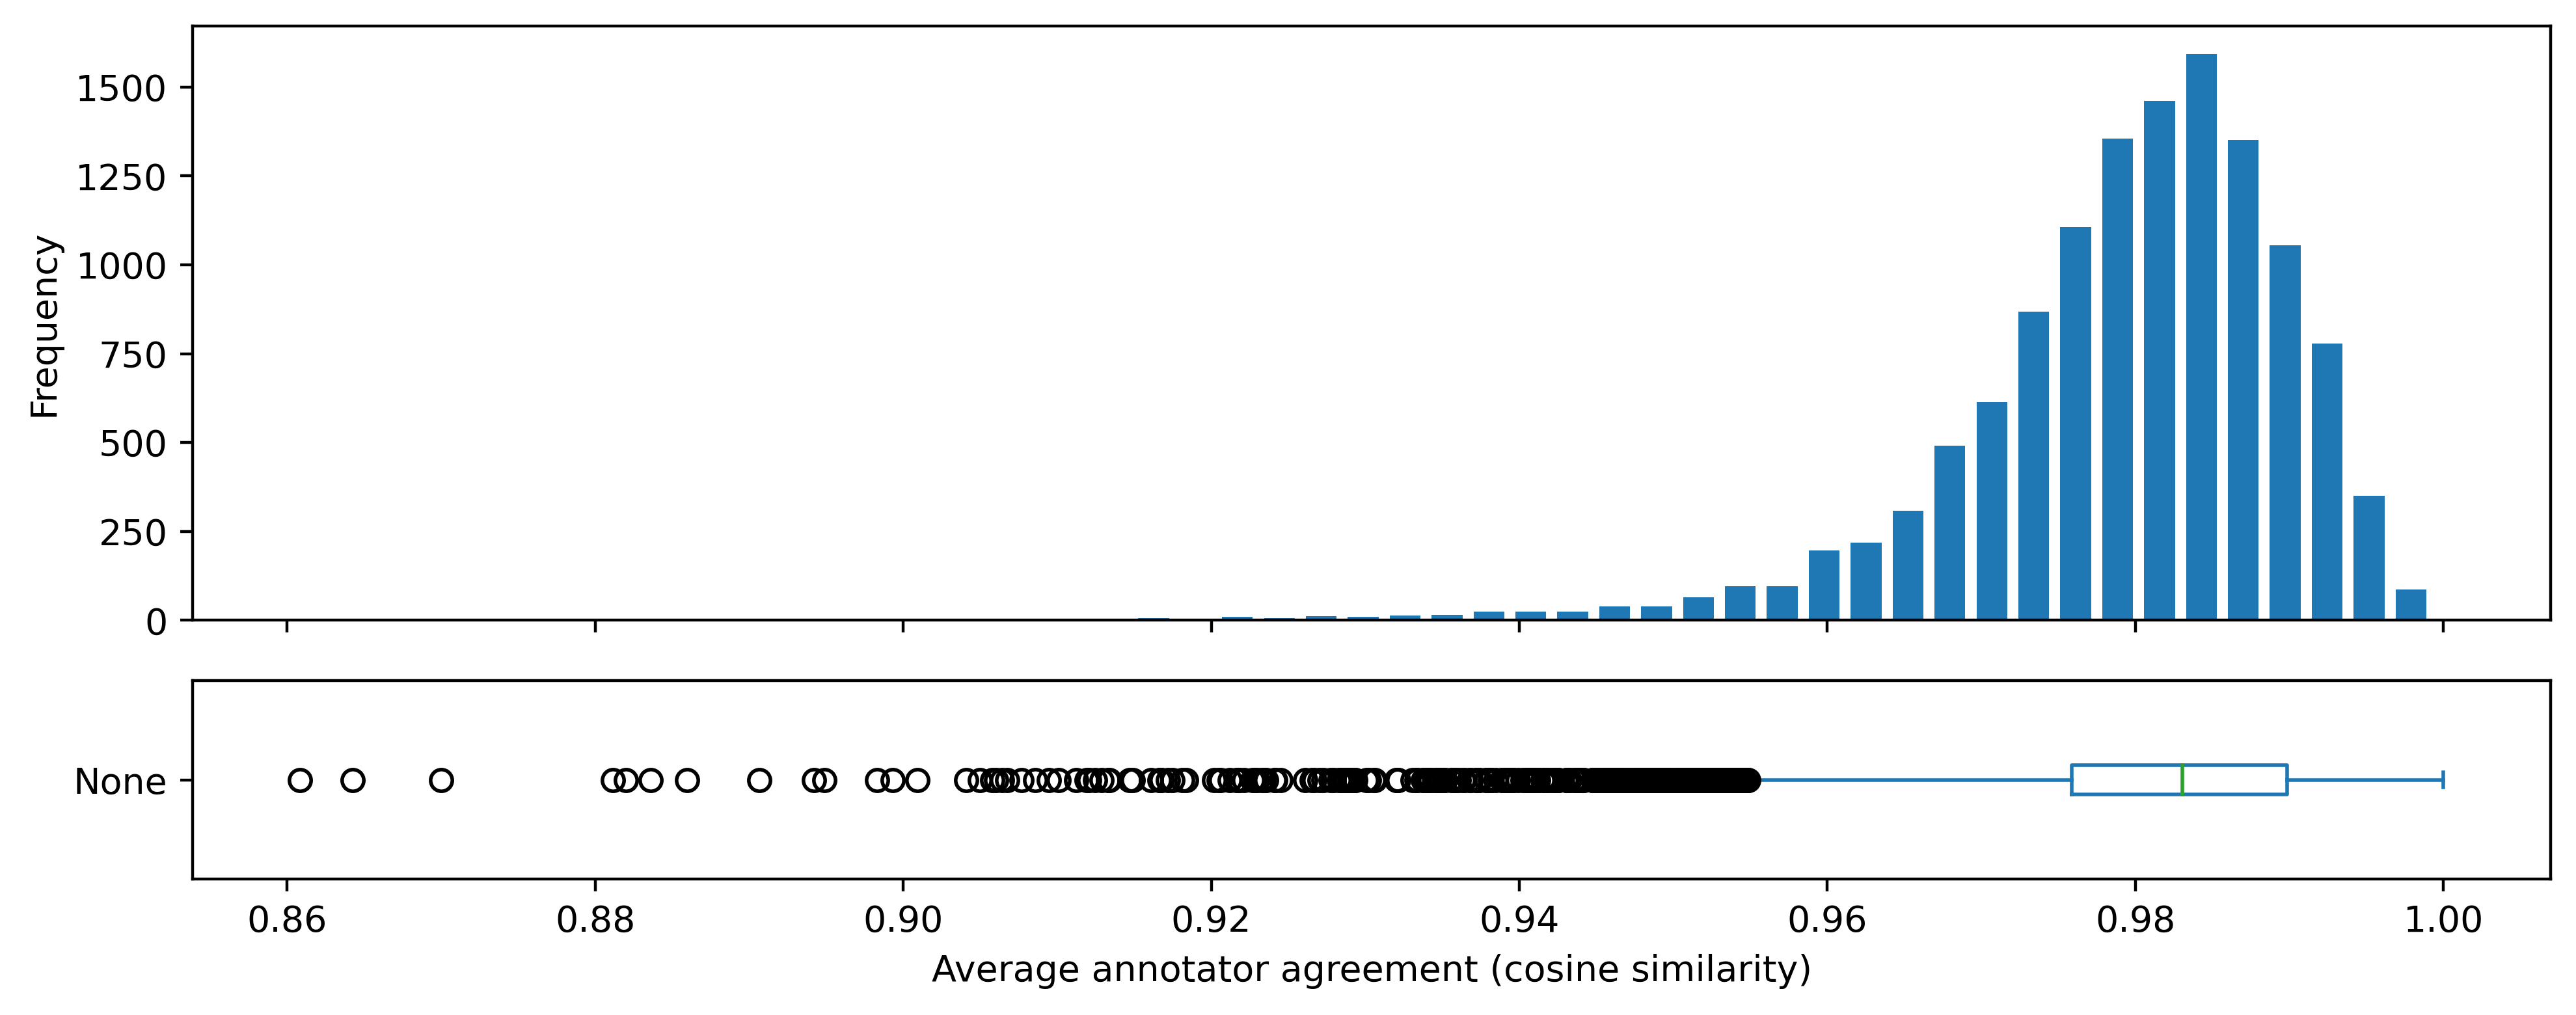

In [225]:
from matplotlib import gridspec

plt.figure(figsize=(10,10), dpi=400)
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax0 = okvqa['full'].annotator_agreement_cos[cond].plot(kind='hist', width=0.002, bins=51,ax=ax0)
ax0.set_xlabel('Average cosine similarity between answers')

ax1 = plt.subplot(gs[1], sharex=ax0)
ac1 = similarities[cond].plot(kind='box', figsize=(10,4), vert=False, ax=ax1)
ax1.set_xlabel('Average annotator agreement (cosine similarity)')

plt.tight_layout()
plt.show()


In [173]:
similarities.describe()

count    14055.000000
mean         0.982108
std          0.012561
min          0.860840
25%          0.975850
50%          0.983067
75%          0.989839
max          1.000000
dtype: float64

So as we see from the average cosine distance between the answer embeddings (when some of the 10 answers differ), they are quite similar as the similarity distribution is a bell-like curve with an average at around 0.97. Remembering that the cosine similarity metric can take values within the range [-1,1], the annotator agreement is quite impressive with a minimum value of 0.7 and a maximum of 0.999. This suggests that the questions are in general answerable and not too complex in terms of the common understanding of the questions and that questions - in spite of sometimes having differing answers - have a quite low ambiguity since differing answers are related (within the `sent2vec` embedding space).

In [180]:
QA['annotator_agreement_cos'] = okvqa['full']['annotator_agreement_cos']
QA.head()

,question_str,question_tokens,answers,question_type,question_length,answer_length,answer_var,annotator_agreement_cos
0,What is the hairstyle of the blond called?,"[what, is, the, hairstyle, of, the, blond, cal...","[pony tail, pony tail, pony tail, pony tail, p...",four,8,1.6,3,0.982934
1,How old do you have to be in canada to do this?,"[how, old, do, you, have, to, be, in, canada, ...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]",seven,12,1.0,1,NaN
2,Can you guess the place where the man is playing?,"[can, you, guess, the, place, where, the, man,...","[aspen, aspen, mountain, mountain, mountain, m...",four,10,1.2,4,0.980772
3,Which rail company is named after a town in ne...,"[which, rail, company, is, named, after, a, to...","[santa fe, santa fe, santa fe, santa fe, new e...",one,11,1.8,4,0.971415
4,Is the boy swimming or doing another water act...,"[is, the, boy, swimming, or, doing, another, w...","[another activity, another activity, another a...",seven,9,1.4,4,0.966226


Let's once again try to manually inspect the top and bottom QA-pairs, now wrt. the cosine similarity.

In [189]:
print_top(df=QA, attribute='annotator_agreement_cos', n=10)

--------------------------------------------------------------------------------
Top 10 (annotator_agreement_cos) QA-pairs:
--------------------------------------------------------------------------------
Question:
 How much sleep does this aged person need?

Answer:
 Counter({'8 hours': 8, '10 hours': 2})

annotator_agreement_cos: 0.9996107220649719
--------------------------------------------------------------------------------
Question:
 Approximately how tall is the building behind the animal shown here?

Answer:
 Counter({'20 feet': 6, '30 feet': 4})

annotator_agreement_cos: 0.9995604753494263
--------------------------------------------------------------------------------
Question:
 How long is his tail mane?

Answer:
 Counter({'3 feet': 6, '4 feet': 4})

annotator_agreement_cos: 0.9994358420372009
--------------------------------------------------------------------------------
Question:
 How far can this animal jump?

Answer:
 Counter({'8 feet': 8, '5 feet': 2})

annotator_agre

In [190]:
print_bottom(df=QA, attribute='annotator_agreement_cos', n=10)

--------------------------------------------------------------------------------
Bottom 10 (annotator_agreement_cos) QA-pairs:
--------------------------------------------------------------------------------
Question:
 How is this food prepared?

Answer:
 Counter({'baked in oven': 4, 'fried': 2, 'oven': 2, 'mix': 2})

annotator_agreement_cos: 0.8608400821685791
--------------------------------------------------------------------------------
Question:
 Why so many green vegetables?

Answer:
 Counter({'healthy': 4, 'make salad': 2, 'lot of vegetable are green': 2, 'salad': 2})

annotator_agreement_cos: 0.8642381429672241
--------------------------------------------------------------------------------
Question:
 How is this desert prepared?

Answer:
 Counter({'baked in oven': 4, 'bake': 2, 'oven': 2, 'baked': 2})

annotator_agreement_cos: 0.8699844479560852
--------------------------------------------------------------------------------
Question:
 What is the stuff in the middle of the pl

Similarly to the count disagreement metric, we here see some interesting trends, even though all QA-pairs in general have a high cosine similarity distribution (with minimum of 0.7). The trends we observe are:

1. that the most similar answers wrt. cosine similarity are mainly due to a systematic numerical "blindness" - i.e. that `16 feet/25 feet/40 feet` are deemed to be very similar.
2. that the most dissimilar answers seem to have several possible explanations for having a lower cosine similarity:
    - difference in answer length
    - subjectivity, like why or which answers with the option to answer ambiguously
    - spelling errors 
    - regular disagreement - like determining what is in the middle of an image.

Wrt. 1) this raises a potential issue when later on training VQA models, since such annotations - from a manual point of view - are not nearly related in their essence, solely in the structure of the answer. The ideal thing that a VQA system should learn, would be to answer correctly wrt. facts - not answer correctly wrt. lingual structure.

The explanations for the lower cosine similarity similarly reveals some issues to have in mind when training and evaluating our VQA models in the future. Even though long and short answers with similar content have a high similarity, the difference in length might be an issue if evaluating the VQA system with certain metrics (such as edit distance compared to cosine similarity).

### QA - Principle Component Analysis (Not fully done..)

Let's try to see if there is a natural clustering occuring by investigating the question embeddings through principle component analysis.

In [191]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

We start by vectorizing questions using `sent2vec`s `Vectorizer()` method

In [128]:
# initialize parameters
vectorizer = Vectorizer()

# vectorize questions
for question in tqdm(okvqa['full'].question_str):
    question = [question]

    # vectorize the questions
    vectorizer.run(question)
    vectors = vectorizer.vectors

# get dataframe
X = np.array(vectors)

Initializing Bert distilbert-base-uncased
Vectorization done on cpu


Then PCA needs a standardized version of the data matrix.

In [129]:
# standardize data
X = StandardScaler().fit_transform(np.array(vectors))

assert np.allclose(X.mean(axis=0), 0, atol=1e-5)
assert np.allclose(X.std(axis=0), 1, atol=1e-5)

Let's fit the PCA to our data and transform the data. We initialize by looking at the accumulated explained variance within the principle components.

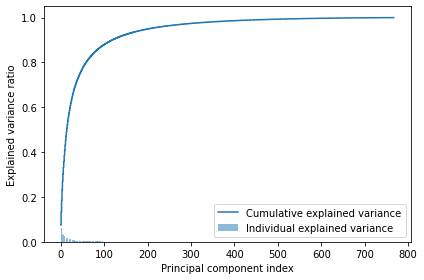

-----------------------------------
Accumulated explained variance:
-----------------------------------
PC1) 7.48%
PC2) 13.43%
PC3) 18.45%
PC4) 23.31%
PC5) 26.88%
PC6) 30.24%
PC7) 33.20%
PC8) 35.81%
PC9) 38.38%
PC10) 40.77%


In [130]:
n_components = 10

# create principle component analysis
pca = PCA()
PC = pca.fit_transform(X)
exp_var_pca = pca.explained_variance_ratio_

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(exp_var_pca.cumsum())), exp_var_pca.cumsum(), where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print(f"{'-'*35}\nAccumulated explained variance:\n{'-'*35}")
for i, explained_var in enumerate(exp_var_pca.cumsum()[:n_components]):
    print(f"PC{i+1}) {explained_var*100:.2f}%")

So, the accumulated explained variance is quite low - after 10 PCs the explained variance is still only 40% so the PCs might not be super good for intuitively visualizing the data in a lower dimensionality. Let's try anyway!

In [131]:
n_components = 10

# create principle component analysis
pca = PCA(n_components=n_components)
PC = pca.fit_transform(X)

# collect in dataframe
temp = pd.DataFrame(data = PC, columns = [f'PC{i+1}' for i in range(n_components)])

# add variables
q3, q1 = np.percentile(QA['annotator_agreement_cos'].dropna(), [75, 25])

temp['cosine'] = pd.cut(QA['annotator_agreement_cos'].fillna(1),
                        bins=[-1, q1, q3, 1], 
                        labels=['low', 'medium','high'],
                        right=True,)
temp['answer_var'] = QA['answer_var']
temp['question_type'] = QA['question_type'].map(q_type)
temp.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cosine,answer_var,question_type
0,0.584179,-5.527318,7.766827,-2.475471,1.797551,6.929830,3.686437,-1.225027,-4.127465,0.571580,medium,3,Sports and Recreation
1,-2.993806,-0.145957,1.199773,0.777495,-2.888984,-5.258973,7.992448,6.508821,7.336626,3.724795,high,1,People and Everyday life
2,-3.356586,-9.367735,4.061334,2.838932,-3.526462,1.079309,3.931955,-2.580347,9.761195,6.903039,medium,4,Sports and Recreation
3,8.603512,-2.751765,-2.777468,0.839419,4.322464,-8.950838,6.613410,3.271392,3.321722,3.916754,low,4,Vehicles and Transportation
4,3.835234,2.917182,-0.096810,8.095777,-3.912340,20.622812,2.580779,1.813886,2.835305,10.920443,low,4,People and Everyday life


We will try to see if there is an clustering of the question embeddings in a 2D PC space by coloring the coordinates based on the associated cosine similarity and answer variability.

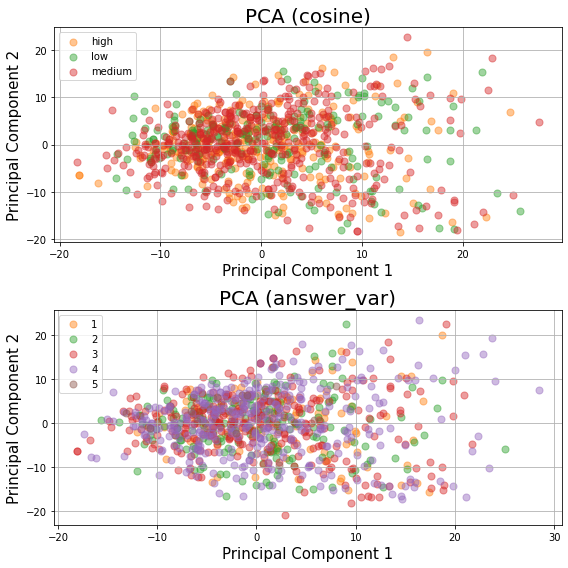

In [132]:
fig = plt.figure(figsize=(8,8))

ax0, _ = plot_PCA(fig, temp.sample(1000), 'cosine', subplot=211, chosen_PCs=(1,2))
ax1, _ = plot_PCA(fig, temp.sample(1000), 'answer_var', subplot=212, chosen_PCs=(1,2))
plt.tight_layout()
plt.show()

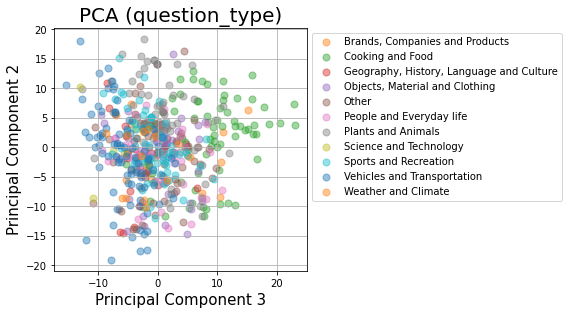

In [134]:
fig = plt.figure(figsize=(8,8))

ax, targets = plot_PCA(fig, temp.sample(500), 'question_type', subplot=211, chosen_PCs=(3,2))
ax.legend(targets, bbox_to_anchor=(1, 1))
plt.tight_layout()



## 4) Save Data
We save the data such that it can be used in the other data investigations.

In [65]:
okvqa['full'].drop(['ocr_tokens'], axis=1, inplace=True)

In [69]:
okvqa['full'].to_json('data/OKVQA_text.json')

## Conclusions and considerations:

Through investigations of the data, we get a first intuition of the prerequisites for later explaining VQA model performance. Thus, through this investigation multiple things became evident to us:

Questions:
> - Questions vary a lot in length (between 2 and 33 word tokens)
> - They are highly biased towards having the word *what* as a start word (approx. 70%). The start-word distribution follow a power law.

Answers:
> - A Question-Image (QI) pair has 10 annotated answers. These are quite short with 91.75% having an average length below 2 word tokens. 
> - Most QI-pairs have at least 2 annotated answers that are not identical but no more than 5 differing answers are to be observed. Using `sent2vec` and `sklearn`'s `cosine_similarity` it turns out that the differing answers within a QI-pair are in general close to eachother in terms of the essence/meaning of the answer. 
> - For differing answers, the most similar ones (wrt. cosine similarity), are typically related to numbers like `20 feet/30 feet` and `5 hours / 10 hours` or such answers. Even though this similarity metric suggests these to be super agreeing, we argue that the annotators are in fact not close to answering the answers similarly at all on these types of questions (in terms of answering correctly). This is a critical point about the dataset that might negatively influence the model performance when validating on such annotated questions.
> - For differing answers, the least similar ones (wrt. cosine similarity), are typically lower in similarity score due to several things; 1) difference in answer length (even though it's cosine sim. it has a say when some answers are single words!), 2) subjectivity, like *why* or *which* answers with the option to answer ambiguously, 3) spelling errors or 4) regular disagreement - like determining what is in the middle of an image.
> - **The various issues raised above are critical to how we choose to evaluate out VQA system.**
